# This file is used to train

In [1]:
import torch
import numpy as np
from tqdm import tqdm
import pandas as pd
from sc_model import SC_LSTM as Model

# Device init

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if device.type == 'cuda':
    !nvidia-smi
    print(torch.cuda.get_device_name(0))

else:
    print("No GPU :(")

Mon Jul 10 18:55:29 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 530.41.03              Driver Version: 530.41.03    CUDA Version: 12.1     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                  Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf            Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce GTX 1650 Ti      Off| 00000000:01:00.0 Off |                  N/A |
| N/A   39C    P5                7W /  N/A|    450MiB /  4096MiB |     24%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [3]:
device = 'cpu'

## Loading the data

In [4]:
from Data.PreprocessorOfGeneratedData import Preprocessor

preproc = Preprocessor()

data = pd.read_csv('../Data/schedule_gen.csv')
data

,Label Number,Duration,Importance,Start Time,Date
0,3,170,3,07:55,11/07/2023
1,0,15,0,12:15,11/07/2023
2,2,30,1,14:15,11/07/2023
3,1,90,0,16:10,11/07/2023
4,2,40,1,18:25,11/07/2023
...,...,...,...,...,...
13404,2,45,2,09:25,30/12/2028
13405,3,170,3,11:50,30/12/2028
13406,1,60,2,16:35,30/12/2028
13407,2,75,2,17:55,30/12/2028


In [5]:
input_data, type_vector, output_data = preproc.preprocess('../Data/schedule_gen.csv')
input_data = np.array(input_data, dtype=np.float64)
pd.DataFrame(input_data)
# input_data

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,0.0,0.0,0.0,1.0,0.708333,0.75,0.006944,0.876727,-0.480989,0.526027,0.790776,-0.612106,-5.000000e-01,-0.866025
1,1.0,0.0,0.0,0.0,0.062500,0.00,-0.327778,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000e+00,1.000000
2,0.0,0.0,1.0,0.0,0.125000,0.25,0.265972,-0.555570,-0.831470,0.526027,0.790776,-0.612106,-5.000000e-01,-0.866025
3,0.0,1.0,0.0,0.0,0.375000,0.00,0.345833,-0.887011,-0.461749,0.526027,0.790776,-0.612106,-5.000000e-01,-0.866025
4,0.0,0.0,1.0,0.0,0.166667,0.25,0.439583,-0.994056,0.108867,0.000000,0.000000,1.000000,0.000000e+00,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13404,0.0,0.0,1.0,0.0,0.187500,0.50,-0.011806,0.000000,1.000000,1.000000,-0.201299,0.979530,-2.449294e-16,1.000000
13405,0.0,0.0,0.0,1.0,0.708333,0.75,-0.011806,0.000000,1.000000,1.000000,-0.201299,0.979530,-2.449294e-16,1.000000
13406,0.0,1.0,0.0,0.0,0.250000,0.50,0.679167,-0.932008,-0.362438,0.000000,0.000000,1.000000,0.000000e+00,1.000000
13407,0.0,0.0,1.0,0.0,0.312500,0.50,0.734722,-0.999762,-0.021815,1.000000,-0.201299,0.979530,-2.449294e-16,1.000000


In [6]:
# Make the data positive
output_data = np.abs(np.array(output_data, dtype=np.float64))
pd.DataFrame(output_data)

,0,1,2
0,0.006944,0.115278,0.002778
1,0.327778,0.010417,0.000000
2,0.265972,0.020833,0.000000
3,0.345833,0.062500,0.000000
4,0.439583,0.027778,0.000000
...,...,...,...
13404,0.011806,0.031250,0.000000
13405,0.011806,0.124306,0.006250
13406,0.679167,0.041667,0.000000
13407,0.734722,0.052083,0.000000


## Creating the dataset

In [7]:
from torch.utils.data import Dataset, DataLoader

class ScheduleDataset(Dataset):
    def __init__(self, input_data, type_vector, output_vector, task_types='all', transform=None):
        if task_types == 'all':
            self.input_data = input_data
            self.type_vector = type_vector
            self.output_vector = output_vector
        elif task_types == 'resched':
            self.input_data = []
            self.type_vector = []
            self.output_vector = []
            for i in range(len(input_data)):
                if type_vector[i] == "resched":
                    self.input_data.append(input_data[i])
                    self.type_vector.append(type_vector[i])
                    self.output_vector.append(output_vector[i])
        elif task_types == 'non-resched':
            self.input_data = []
            self.type_vector = []
            self.output_vector = []
            for i in range(len(input_data)):
                if type_vector[i] == "non-resched":
                    self.input_data.append(input_data[i])
                    self.type_vector.append(type_vector[i])
                    self.output_vector.append(output_vector[i])
        else:
            raise ValueError("task_types must be 'all', 'resched', or 'non-resched'")
        self.transform = transform

    def __len__(self):
        return len(self.input_data)

    def __getitem__(self, idx):
        return self.input_data[idx], self.type_vector[idx], self.output_vector[idx]

In [8]:
resched_dataset = ScheduleDataset(input_data, type_vector, output_data, task_types='resched')
non_resched_dataset = ScheduleDataset(input_data, type_vector, output_data, task_types='non-resched')
all_dataset = ScheduleDataset(input_data, type_vector, output_data, task_types='all')

print(f"Resched dataset size: {len(resched_dataset)}\n"
      f"Non-resched dataset size: {len(non_resched_dataset)}\n"
      f"All dataset size: {len(all_dataset)}")

Resched dataset size: 10767
Non-resched dataset size: 2642
All dataset size: 13409


## Create dataloaders

In [9]:
batch_size = 1
# resched_dataset_size = len(resched_dataset)
# train_size = int(resched_dataset_size * 0.8)
# test_size = resched_dataset_size - train_size
#
# train_resched_dataset, test_resched_dataset = torch.utils.data.random_split(resched_dataset, [train_size, test_size])

train_resched_dataloader = DataLoader(resched_dataset, batch_size=batch_size)
# valid_resched_dataloader = DataLoader2(resched_dataset, batch_size=batch_size)

train_non_resched_dataloader = DataLoader(non_resched_dataset, batch_size=batch_size)

## Create free time slots generator

In [10]:
from Data.GeneratorOfAvailableTimeslots import GeneratorOfAvailableTimeslots

time_slots_gen = GeneratorOfAvailableTimeslots(5)
time_slots = time_slots_gen.generate_available_timeslots()

time_slots      # TODO: why all the intervals are closed?
single_interval = time_slots[0]
single_interval


array([[0.02107833, 0.05790056],
       [0.34214843, 0.3652735 ],
       [0.48332587, 0.50445007],
       [0.69542685, 0.69649255],
       [0.70214784, 0.71850623],
       [0.76948443, 0.78864327],
       [0.79131819, 0.8612246 ],
       [0.90193633, 0.90258482],
       [0.93584193, 0.94736491],
       [0.96836672, 0.96941589],
       [0.97479902, 0.97530908],
       [0.98630203, 0.98699735],
       [0.99360859, 0.99379637]])

## Init the model

In [11]:
# check if the dataloader works and get the input and output sizes
in_features = None
out_features = None
for i, (features, a, ans) in enumerate(train_resched_dataloader):
    in_features = features.shape[1]             # 14
    out_features = ans.shape[1]                 # 3
    break

n_layers = 1
hidden_size = 124
hidden_injector = 64

# Create the model
SC_LSTM = Model(in_features, n_layers, hidden_size, out_features, batch_size, hidden_injector=hidden_injector).to(device)

# Training the model

In [12]:
# Configure hyper-parameters
epochs = 3
learning_rate = 0.001
loss_func = torch.nn.MSELoss()
optimizer = torch.optim.Adam(SC_LSTM.parameters(), lr=learning_rate)

history = []
loss_accomulator = []
mean_loss = None

In [13]:
# Firstly train the LSTM using only reschedulable tasks
SC_LSTM.train_model(mode='lstm')

for epoch in range(0, epochs):
    SC_LSTM.reset_states()
    for i, (X, task_type, Y) in enumerate(tqdm(train_resched_dataloader, desc=f"Epoch: {epoch + 1}, Mean Loss: {mean_loss}", leave=False, colour='green')):

        # Convert X and Y to the correct type
        X = torch.Tensor(X).type(torch.float32).to(device)
        Y = torch.Tensor(Y).type(torch.float32).to(device)

        # Make prediction
        Y_pred = SC_LSTM.forward(X, task_type=task_type, free_time_slots=single_interval, save_states=True)

        # Calculate loss
        loss = loss_func(Y_pred.view(-1, ), Y.view(-1, ))

        # print(f"Predicted: {Y_pred[0]}\n Real: {Y[0]}\n")

        # Backward pass
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        # Append loss to list
        loss_accomulator.append(loss.item())

    mean_loss = np.mean(loss_accomulator)
    history.append(mean_loss)
    loss_accomulator = []

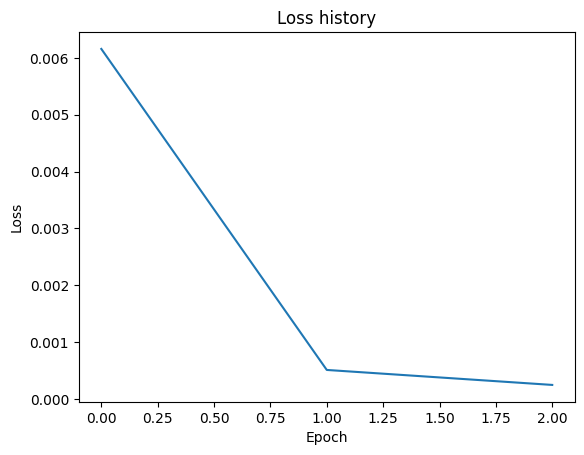

In [14]:
import matplotlib.pyplot as plt
# Plot the loss history
plt.plot(history)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss history")
plt.show()

In [15]:
# Configure hyper-parameters
epochs = 1
learning_rate = 0.001
loss_func = torch.nn.MSELoss()
optimizer = torch.optim.Adam(SC_LSTM.parameters(), lr=learning_rate)

history = []
loss_accomulator = []

In [16]:
# Now train the injector using non-reschedulable tasks
SC_LSTM.train_model(mode='injector')

for epoch in range(0, epochs):
    SC_LSTM.reset_states()

    for i, (X, task_type, Y) in enumerate(tqdm(train_non_resched_dataloader, desc=f"Epoch: {epoch + 1}, Mean Loss: {mean_loss}", leave=False, colour='green')):

        # Convert X and Y to the correct type
        X = torch.Tensor(X).type(torch.float32).to(device)
        Y = torch.Tensor(Y).type(torch.float32).to(device)

        # Make prediction
        Y_pred = SC_LSTM.forward(X, task_type=task_type, free_time_slots=single_interval, save_states=True)

        # Calculate loss
        loss = loss_func(Y_pred.view(-1, ), Y.view(-1, ))

        # Backward pass
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        # Append loss to list
        loss_accomulator.append(loss.item())

    mean_loss = np.mean(loss_accomulator)
    history.append(mean_loss)
    loss_accomulator = []

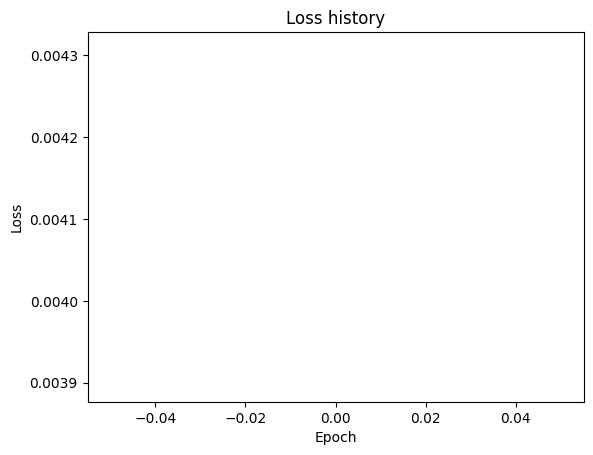

In [17]:
# Plot the loss history
plt.plot(history)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss history")
plt.show()

# Save weights

In [18]:
torch.save(SC_LSTM.state_dict(), "sc_lstm_weights.pth")